In [7]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import pandas as pd
import os
import json
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
#from bag_of_words import ParseData
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer

# %load_ext autoreload
# %autoreload 2

In [8]:
# Conferences
conf = ['acl_2017', 'arxiv.cs.ai_2007-2017', 'arxiv.cs.cl_2007-2017', 'arxiv.cs.lg_2007-2017', 'conll_2016', 'iclr_2017']

# JSON files to be parsed
dir_path    = '../PeerRead/data/'
train_path  = '/train/reviews/'
test_path   = '/test/reviews/'

In [9]:
from Dataparser import get_all_json, create_dataframe, create_label_df, preprocess_text
import pandas as pd

datapath = '../PeerRead/data/'
paths = {
  'acl': 'acl_2017',
  'cs_ai': 'arxiv.cs.ai_2007-2017',
  'cs_cl': 'arxiv.cs.cl_2007-2017',
  'cs_lg': 'arxiv.cs.lg_2007-2017',
  'conll': 'conll_2016',
  'iclr': 'iclr_2017',
  'nips': 'nips_2013-2017'
}

dataset_names = ['acl', 'cs_ai', 'cs_cl', 'cs_lg', 'conll', 'iclr']
num_datasets = len(dataset_names)
dataset_data = [get_all_json(datapath + paths[s]) for s in dataset_names]

parent_paths = [datapath + paths[s] for s in dataset_names]
review_paths = sum([[path + '/dev/reviews', path + '/test/reviews', path + '/train/reviews'] for path in parent_paths], [])

training_data = [create_dataframe(data[4], data[5], dataset_name=i) for i,data in enumerate(dataset_data)]
testing_data = [create_dataframe(data[2], data[3]) for data in dataset_data]

testing_dfs = [pd.DataFrame(testing_data[i]) for i in range(num_datasets)]
training_dfs = [pd.DataFrame(training_data[i]) for i in range(num_datasets)]

### only labels
'''
test_label_data = [create_label_df(review_path,testing_df=testing_dfs[i//3]) for i, review_path in enumerate(review_paths)]
train_label_data = [create_label_df(review_path,testing_df=training_dfs[i//3]) for i, review_path in enumerate(review_paths)]


test_label_dfs = [pd.DataFrame(test_label_data[i]) for i in range(num_datasets)]
train_label_dfs = [pd.DataFrame(train_label_data[i]) for i in range(num_datasets)]
'''
##

'\ntest_label_data = [create_label_df(review_path,testing_df=testing_dfs[i//3]) for i, review_path in enumerate(review_paths)]\ntrain_label_data = [create_label_df(review_path,testing_df=training_dfs[i//3]) for i, review_path in enumerate(review_paths)]\n\n\ntest_label_dfs = [pd.DataFrame(test_label_data[i]) for i in range(num_datasets)]\ntrain_label_dfs = [pd.DataFrame(train_label_data[i]) for i in range(num_datasets)]\n'

In [10]:
testing_dfs[1]

,id,title,titleLen,numAuthors,numReferences,numCitedReferences,numRecentReferences,avgCitedRefLength,abstract,abstractLength,abstractFleschScore,abstractDaleChallScore,avgSentenceLength,mentionsAppendix,avgReviewerConf,avgOrig,avgAppro,avgImpact,avgClarity,accepted
0,0804.0188,Support Vector Machine Classification with Ind...,61,2,31,47,1,434.595745,We propose a method for support vector machine...,684,13.611353,9.216448,145.384354,0,None,None,None,None,None,1
1,0903.0467,The Parameterized Complexity of Global Constra...,50,6,20,0,0,0.000000,We argue that parameterized complexity is a us...,848,22.038846,6.629835,94.111111,0,None,None,None,None,None,1
2,0911.1021,Examples as Interaction: On Humans Teaching a ...,69,2,25,0,1,0.000000,This paper reviews an experiment in human-comp...,736,16.328209,8.489013,186.216216,0,None,None,None,None,None,0
3,0912.4879,Similarit\'e en intension vs en extension : \`...,96,2,0,0,0,0.000000,La mise en scène de théâtre traditionnelle rep...,420,6.677500,16.785095,195.186667,0,None,None,None,None,None,0
4,1005.1567,On The Power of Tree Projections: Structural T...,86,2,20,45,0,230.688889,The problem of deciding whether CSP instances ...,1184,-0.807016,8.766053,134.858974,0,None,None,None,None,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,1706.00536,Latent Attention Networks,25,6,30,35,0,142.742857,Deep neural networks are able to solve tasks a...,1086,2.060645,9.553576,145.793103,0,None,None,None,None,None,0
201,1706.03661,DAC-h3: A Proactive Robot Cognitive Architectu...,110,19,86,109,0,148.394495,This paper introduces a cognitive architecture...,906,-10.743825,9.128674,149.229675,0,None,None,None,None,None,0
202,1706.04972,Device Placement Optimization with Reinforceme...,57,10,37,42,1,169.190476,The past few years have witnessed a growth in ...,1134,20.863295,8.527563,131.836364,0,None,None,None,None,None,1
203,1707.05224,"Detection, Recognition and Tracking of Moving ...",127,3,22,49,0,80.510204,"In this paper, we address the basic problem of...",1503,17.165071,9.217513,126.852665,0,None,None,None,None,None,0


In [11]:
train_title = []
test_title  = []
train_label = []
test_label  = []

for i in range(num_datasets):  
    for n in range(len(training_data[i])):
        #print(training_data[i][n]['title'])
        train_title.extend([training_data[i][n]['title']])
        train_label.extend([training_data[i][n]['accepted']])
        
    for k in range(len(testing_data[i])):
        test_title.extend([testing_data[i][k]['title']])
        test_label.extend([testing_data[i][k]['accepted']])

## support for old code
merged_data = []
merged_data.extend(train_title)
merged_data.extend(test_title)

## title only test
train_data = train_title
test_data = test_title

print(len(merged_data), len(train_data), len(test_data))

11727 11090 637


In [12]:
from Dataparser import preprocess_text

# Getting bag of words definition from our corpus of data
bowVec = CountVectorizer(ngram_range=(1,1), preprocessor=preprocess_text, stop_words='english')
bowVec = bowVec.fit(merged_data)

## get BOW feature rep
X_train = bowVec.transform(train_data)  
X_test = bowVec.transform(test_data)

print(X_train.shape, X_test.shape, len(train_data))

## display 
cv_dataframe = pd.DataFrame(X_train.toarray(),columns=bowVec.get_feature_names_out())
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
display(cv_dataframe.head(5).loc[:,cv_dataframe.head(5).any()])

(11090, 9172) (637, 9172) 11090


,annotation,answering,attention,base,based,bridge,cross,detection,effective,embedding,...,overlapping,projection,prototype,question,recognition,relation,representation,supervised,text,weakly
0,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,1,0,...,0,1,0,0,1,0,1,1,0,1
3,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,0,1,0,1,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0


In [13]:
# Dimension reduction on BOW using SVD
on_svd = False

svd = TruncatedSVD(n_components=500, n_iter=10, random_state=42)
X_new = svd.fit(X_train)
X_train_svd = svd.transform(X_train)
X_test_svd = svd.transform(X_test)

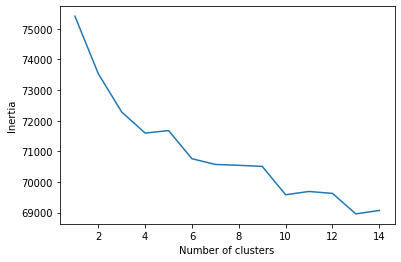

In [14]:
# Cluster documents based on BOW model
bow_distortions = []
K = range(1,15)

for k in K:
    bow_model = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10)
    if(on_svd):
        bow_model.fit(X_train_svd)
    else:
        bow_model.fit(X_train)
    bow_distortions.append(bow_model.inertia_)

plt.plot(K, bow_distortions)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
# print(distortions)

# Choosing the best k from elbow method.
true_k = 6
bow_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=10)

if(on_svd):
    bow_model.fit(X_train_svd)
else:
    bow_model.fit(X_train)

Top terms per cluster:


/mnt/c/Users/Andre/miniconda3/envs/ml_proj/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


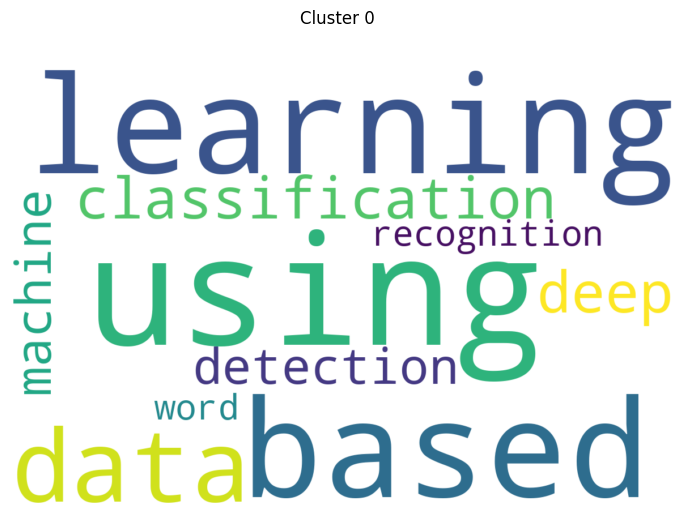

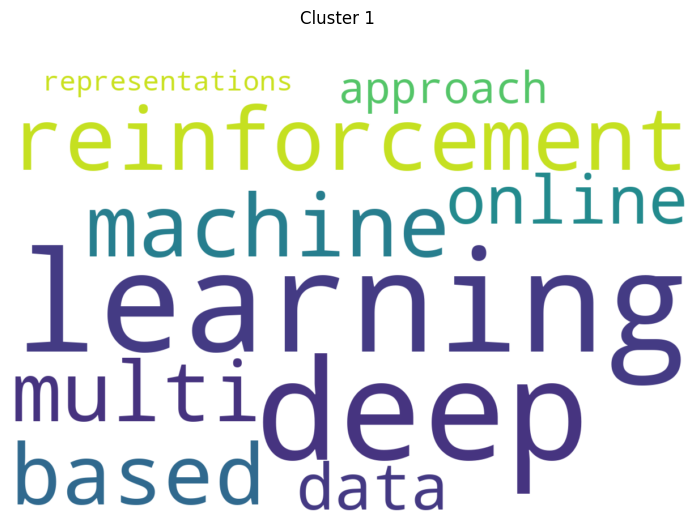

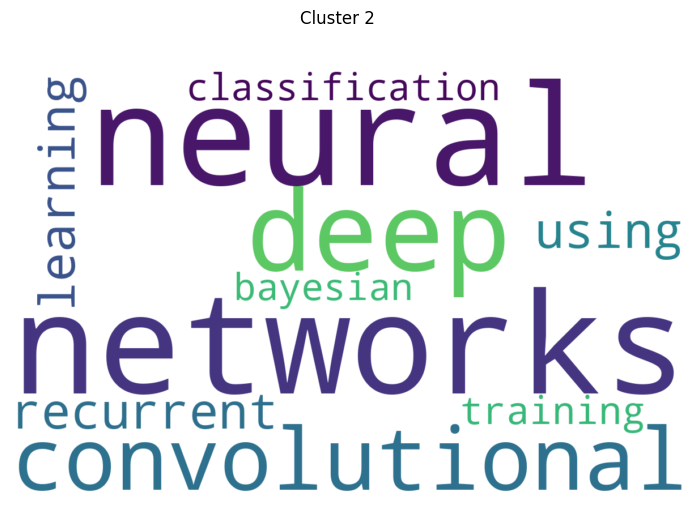

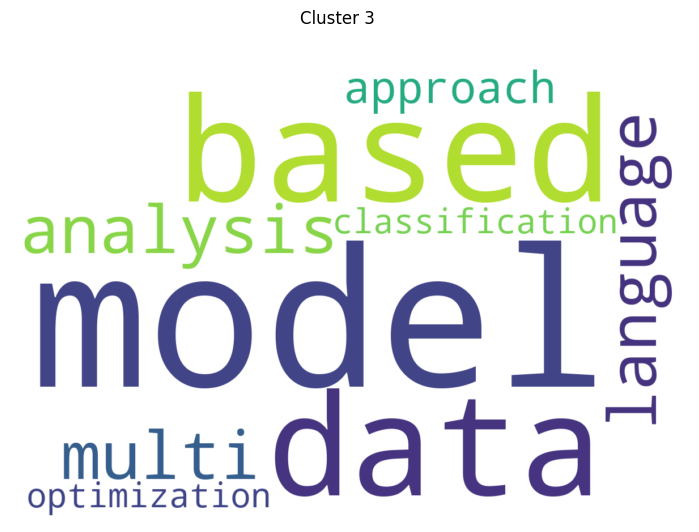

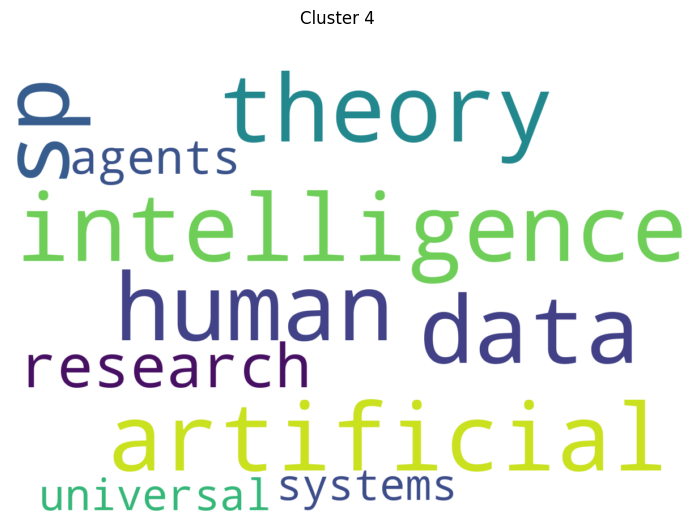

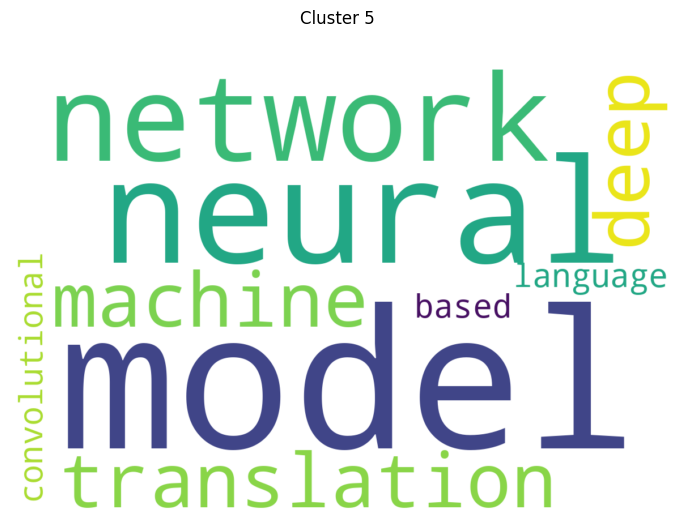

In [15]:
# Print top terms per cluster and generate word clouds for BOW model
print("Top terms per cluster:")
bow_order_centroids = bow_model.cluster_centers_.argsort()[:, ::-1]
terms = bowVec.get_feature_names()
for i in range(true_k):
    # print("Cluster %d:" % i)
    words = ""
    for ind in bow_order_centroids[i, :10]:
        words = words + terms[ind] + " "
        # print (' %s' % terms[ind])
    wordcloud = WordCloud(width=1200, height=800, background_color="white").generate(words)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    fig.suptitle(f"Cluster {i}")
    plt.show()

In [16]:
# Testing the Clustering based on BOW model
# Predict the cluster association of each paper

prediction = bow_model.predict(X_test)
print(X_train.shape)
print(X_test.shape)
df = pd.DataFrame(list(zip(test_title, prediction)), columns =['Title', 'Cluster ID'])
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# display(df)
print(df.head(10).loc[:,df.head(10).any()].to_markdown())
# display(df.loc[df['Cluster ID'] == 1])

(11090, 9172)
(637, 9172)
|    | Title                                                                                              |   Cluster ID |
|---:|:---------------------------------------------------------------------------------------------------|-------------:|
|  0 | Evaluation Metrics for Machine Reading Comprehension: Prerequisite Skills and Readability          |            3 |
|  1 | A Neural Local Coherence Model                                                                     |            5 |
|  2 | Neural Modeling of Multi-Predicate Interactions for Japanese Predicate Argument Structure Analysis |            5 |
|  3 | Neural Disambiguation of Causal Lexical Markers based on Context                                   |            5 |
|  4 | Chunk-based Decoder for Neural Machine Translation                                                 |            5 |
|  5 | What do Neural Machine Translation Models Learn about Morphology?                                  |      

# Data Preparation

In [33]:
def non_nan_indices(mat):
    return np.array([i for i in range(mat.shape[0]) if not np.any(np.isnan(mat[i]))])

combine_dfs = lambda frame_arr, indices: pd.concat([frame_arr[i] for i in indices], axis=0)
all_combined_dfs = [pd.concat([training_dfs[i], testing_dfs[i]], axis=0) for i in range(6)]
# training_df = combine_dfs(all_combined_dfs, [2])
#testing_df = combine_dfs(all_combined_dfs, [2])
columns = list(range(2, 8)) + list(range(9, 14)) + [19]
combined_df = combine_dfs(all_combined_dfs, [1, 2, 3])
combined_matrix = combined_df.iloc[:, columns].to_numpy()

# Random sample

np.random.seed(1000)

percent_training = 0.8
percent_accepted = 0.45
accepted_rows = combined_matrix[combined_matrix[:, -1] == 1]
rejected_rows = combined_matrix[combined_matrix[:, -1] == 0]

accepted_indices = np.random.choice(accepted_rows.shape[0], size=accepted_rows.shape[0], replace=False)
accept_split_index = int(accepted_indices.shape[0] * percent_training)
rejected_indices = np.random.choice(rejected_rows.shape[0], size=int(accepted_rows.shape[0] * (1 - percent_accepted) / percent_accepted), replace=False)
reject_split_index = int(rejected_indices.shape[0] * percent_training)
training_matrix = np.concatenate([accepted_rows[accepted_indices, :][:accept_split_index, :], rejected_rows[rejected_indices, :][:reject_split_index, :]], axis=0)
testing_matrix = np.concatenate([accepted_rows[accepted_indices, :][accept_split_index:, :], rejected_rows[rejected_indices, :][reject_split_index:, :]], axis=0)

# Actual matrix definitions

X_train = training_matrix[:, :-1][non_nan_indices(training_matrix), :]
train_label = training_matrix[:, -1][non_nan_indices(training_matrix)]
X_test = testing_matrix[:, :-1][non_nan_indices(testing_matrix)]
test_label = testing_matrix[:, -1][non_nan_indices(testing_matrix)]

# Make sure no NaNs
 
has_nan = lambda mat: np.any([np.isnan(row) for row in mat])

assert not has_nan(X_train)
assert not has_nan(train_label)
assert not has_nan(X_test)
assert not has_nan(test_label)

print(accepted_rows[accepted_indices, :][:accept_split_index, :].shape, rejected_rows[rejected_indices, :][:reject_split_index, :].shape, training_matrix.shape)
print(accepted_rows[accepted_indices, :][accept_split_index:, :].shape, rejected_rows[rejected_indices, :][reject_split_index:, :].shape, testing_matrix.shape)

(2202, 12) (2691, 12) (4893, 12)
(551, 12) (673, 12) (1224, 12)


## Naive Bayes Classifier

Train Accuracy:  51.7988552739166
Test Accuracy:  51.9607843137255


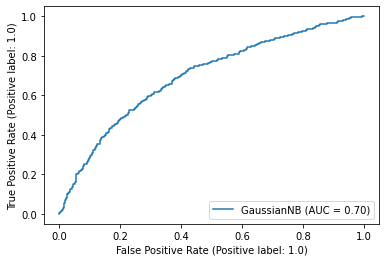

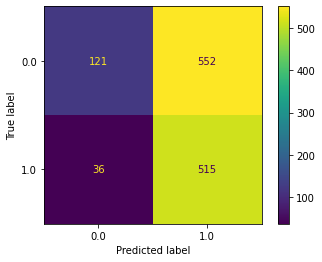

In [18]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

mygnb = GaussianNB()
mygnb = mygnb.fit(X_train, train_label)

## test
#print(mygnb.predict(X_test[0]), test_label[0])

train_preds = mygnb.predict(X_train)
print("Train Accuracy: ", 100*accuracy_score(train_preds, train_label))

test_preds = mygnb.predict(X_test)
print("Test Accuracy: ", 100*accuracy_score(test_preds, test_label))

## visualize
RocCurveDisplay.from_estimator(mygnb, X_test, test_label)
ConfusionMatrixDisplay.from_estimator(mygnb, X_test, test_label)
plt.show()

## KNN Classifier

Best Train Accuracy (# Neighbors: 41):  65.86263286999183
Best Test Accuracy (# Neighbors: 41):  65.0326797385621


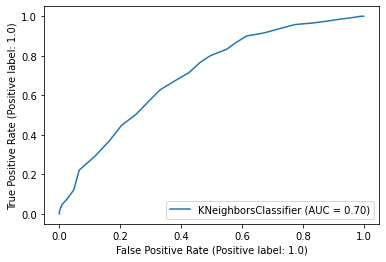

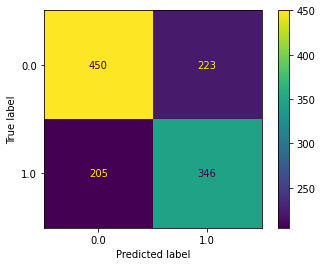

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

## KNN classifier
## hyperparams
best_knn = None
best_train_accuracy = 0.0
best_test_accuracy = 0.0
best_param = 0
hyperparams = range(2, 50)
test_accuracies = []
for num_neighbs in hyperparams:
    myKNN = KNeighborsClassifier(n_neighbors=num_neighbs)
    myKNN.fit(X_train, train_label)
    train_preds = myKNN.predict(X_train)
    test_preds = myKNN.predict(X_test)
    test_accuracies.append(accuracy_score(test_preds, test_label))
    if accuracy_score(test_preds, test_label) > best_test_accuracy:
        best_train_accuracy = accuracy_score(train_preds, train_label)
        best_test_accuracy = accuracy_score(test_preds, test_label)
        best_knn = myKNN
        best_param = num_neighbs

print("Best Train Accuracy (# Neighbors: %d): " % best_param, 100*best_train_accuracy)
print("Best Test Accuracy (# Neighbors: %d): " % best_param, 100*best_test_accuracy)

## visualize
RocCurveDisplay.from_estimator(best_knn, X_test, test_label)
ConfusionMatrixDisplay.from_estimator(best_knn, X_test, test_label)
plt.show()


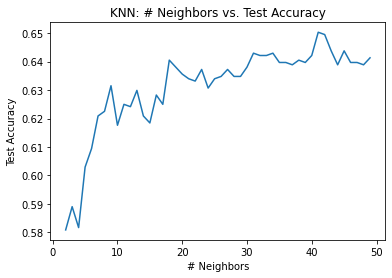

In [20]:
plt.plot(hyperparams, test_accuracies)
plt.xlabel('# Neighbors')
plt.ylabel('Test Accuracy')
plt.title('KNN: # Neighbors vs. Test Accuracy')
plt.show()

## Logistic Regression 

Train Accuracy:  64.37040065412918
Test Accuracy:  64.54248366013073


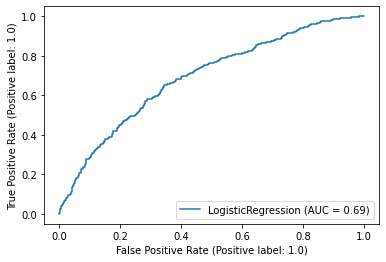

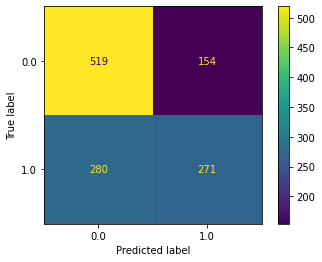

In [21]:
from sklearn.linear_model import LogisticRegression

mylreg = LogisticRegression(max_iter=10000)
mylreg = mylreg.fit(X_train, train_label)

## test
#print(mylreg.predict(X_test[0]), test_label[0])

train_preds = mylreg.predict(X_train)
print("Train Accuracy: ", 100*accuracy_score(train_preds, train_label))

test_preds = mylreg.predict(X_test)
print("Test Accuracy: ", 100*accuracy_score(test_preds, test_label))

## visualize
RocCurveDisplay.from_estimator(mylreg, X_test, test_label)
ConfusionMatrixDisplay.from_estimator(mylreg, X_test, test_label)
plt.show()

## Decision Tree Classifier

Train Accuracy:  100.0
Test Accuracy:  62.66339869281046


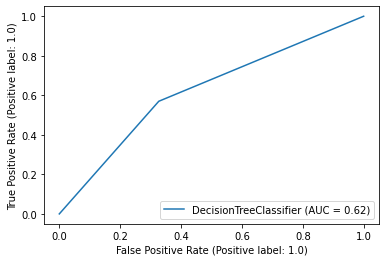

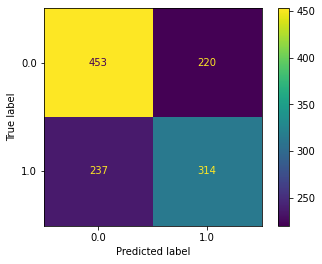

In [22]:
from sklearn import tree
from sklearn.metrics import accuracy_score

mydtree = tree.DecisionTreeClassifier()
mydtree = mydtree.fit(X_train, train_label)

## test
#print(mydtree.predict(X_test[0]), test_label[0])

train_preds = mydtree.predict(X_train)
print("Train Accuracy: ", 100*accuracy_score(train_preds, train_label))

test_preds = mydtree.predict(X_test)
print("Test Accuracy: ", 100*accuracy_score(test_preds, test_label))

## visualize
RocCurveDisplay.from_estimator(mydtree, X_test, test_label)
ConfusionMatrixDisplay.from_estimator(mydtree, X_test, test_label)
plt.show()

## Random Forest Classifier

Best Train Accuracy (n_estimators=200, max_depth=9):  83.50367947669665
Best Test Accuracy (n_estimators=200, max_depth=9):  70.42483660130719


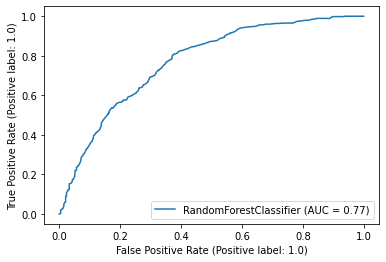

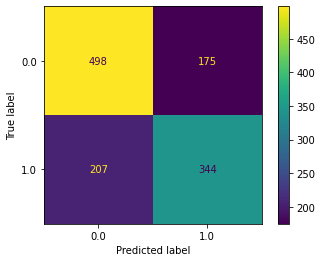

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## hyperparams

n_estimators = 200
max_depths = range(1, 30)
max_test_accuracy = 0.0
max_train_accuracy = 0.0
best_max_depth = 0
test_accuracies = []
for max_depth in max_depths:
    criterion = 'gini' #'entropy'
    myrforest = RandomForestClassifier(max_depth=max_depth, n_estimators= n_estimators, criterion=criterion)
    myrforest = myrforest.fit(X_train, train_label)
    train_preds = myrforest.predict(X_train)
    test_preds = myrforest.predict(X_test)
    train_accuracy = accuracy_score(train_preds, train_label)
    test_accuracy = accuracy_score(test_preds, test_label)
    if test_accuracy > max_test_accuracy:
        max_test_accuracy = test_accuracy
        max_train_accuracy = train_accuracy
        best_max_depth = max_depth
    test_accuracies.append(test_accuracy)

print("Best Train Accuracy (n_estimators=%d, max_depth=%d): " % (n_estimators, best_max_depth), 100*max_train_accuracy)  
print("Best Test Accuracy (n_estimators=%d, max_depth=%d): " % (n_estimators, best_max_depth), 100*max_test_accuracy)

## visualize
RocCurveDisplay.from_estimator(myrforest, X_test, test_label)
ConfusionMatrixDisplay.from_estimator(myrforest, X_test, test_label)
plt.show()


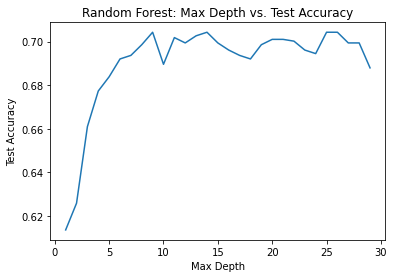

In [24]:
plt.plot(max_depths, test_accuracies)
plt.xlabel('Max Depth')
plt.ylabel('Test Accuracy')
plt.title('Random Forest: Max Depth vs. Test Accuracy')
plt.show()

## SVM Classifier

Train Accuracy:  72.28127555192151
Test Accuracy:  68.54575163398692


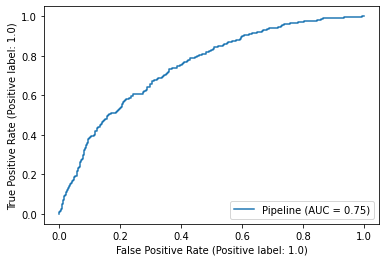

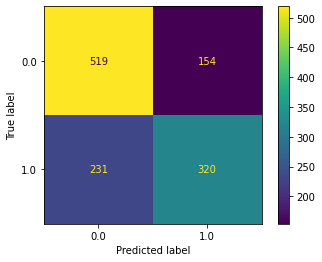

In [25]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler  ## for data centering 
from sklearn.pipeline import make_pipeline   ## sequential pipelining
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

mysvm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
mysvm = mysvm.fit(X_train, train_label)

## test
#print(mysvm.predict(X_test[0]), test_label[0])

train_preds = mysvm.predict(X_train)
print("Train Accuracy: ", 100*accuracy_score(train_preds, train_label))

test_preds = mysvm.predict(X_test)
print("Test Accuracy: ", 100*accuracy_score(test_preds, test_label))

## visualize
RocCurveDisplay.from_estimator(mysvm, X_test, test_label)
ConfusionMatrixDisplay.from_estimator(mysvm, X_test, test_label)
plt.show()


## MLP (neural network) Classifier

0.0001
0
1
2
3
0.0002
0
1
2
3
0.00030000000000000003
0
1
2
3
0.0004
0
1
2
3
0.0005
0
1
2
3
0.0006000000000000001
0
1
2
3
0.0007000000000000001
0
1
2
3
0.0008
0
1
2
3
0.0009000000000000001
0
1
2
3
0.001
0
1
2
3
0.0011
0
1
2
3
0.0012000000000000001
0
1
2
3
0.0013000000000000002
0
1
2
3
0.0014000000000000002
0
1
2
3
0.0015
0
1
2
3
0.0016
0
1
2
3
0.0017000000000000001
0
1
2
3
0.0018000000000000002
0
1
2
3
0.0019000000000000002
0
1
2
3
0.002
0
1
2
3
0.0021
0
1
2
3
0.0022
0
1
2
3
0.0023
0
1
2
3
0.0024
0
1
2
3
0.0025
0
1
2
3
0.0026
0
1
2
3
0.0027
0
1
2
3
0.0028
0
1
2
3
0.0029
0
1
2
3
0.003
0
1
2
3
0.0031
0
1
2
3
0.0032
0
1
2
3
0.0033
0
1
2
3
0.0034
0
1
2
3
0.0035
0
1
2
3
0.0036
0
1
2
3
0.0037
0
1
2
3
0.0038
0
1
2
3
0.0039
0
1
2
3
0.004
0
1
2
3
0.0041
0
1
2
3
0.004200000000000001
0
1
2
3
0.004300000000000001
0
1
2
3
0.0044
0
1
2
3
0.0045000000000000005
0
1
2
3
0.004600000000000001
0
1
2
3
0.0047
0
1
2
3
0.0048000000000000004
0
1
2
3
0.004900000000000001
0
1
2
3
0.005
0
1
2
3
0.0051
0
1
2
3
0.0

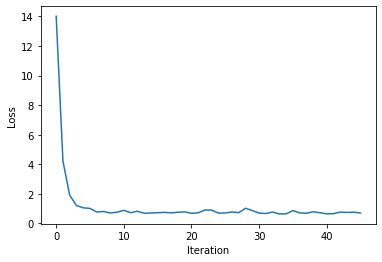

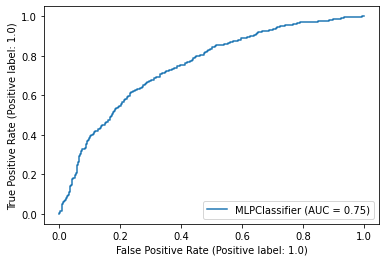

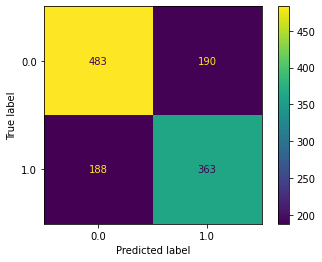

In [26]:
from sklearn.neural_network import MLPClassifier

##hyperparams
# h_lrs = 12
acts = 'relu' #'identity', 'logistic', 'tanh'
solver = 'adam' #'sgd'
l2_reg = 0.01
batch_size = 'auto'
# lr_init = 0.001 #0.001
lr_type = 'adaptive' #'constant', 'invscaling', 'adaptive'
early_stopping = False #True
validation_fraction = 0.05

best_network = None
best_loss_curve = None
best_train_accuracy = 0.0
best_test_accuracy = 0.0
best_lr_init = 0.0
best_h_lrs = 0
test_accuracies = []
for lr_init in np.arange(0.0001, 0.01001, 0.0001):
  print(lr_init)
  for _ in range(4):
    print(_)
    mymlp = MLPClassifier(hidden_layer_sizes=(5, ), activation=acts, early_stopping=early_stopping, 
                        validation_fraction=validation_fraction, solver=solver, 
                          learning_rate_init = lr_init, learning_rate=lr_type, 
                          alpha = l2_reg, batch_size=batch_size, max_iter=1000)
    mymlp = mymlp.fit(X_train, train_label)
    loss_curve = mymlp.loss_curve_
    train_preds = mymlp.predict(X_train)
    test_preds = mymlp.predict(X_test)
    train_accuracy = accuracy_score(train_preds, train_label)
    test_accuracy = accuracy_score(test_preds, test_label)
    test_accuracies.append(test_accuracy)
    if test_accuracy > best_test_accuracy:
      best_network = mymlp
      best_loss_curve = loss_curve
      best_train_accuracy = train_accuracy
      best_test_accuracy = test_accuracy
      best_lr_init = lr_init

h_lrs_test_accuracies = []
best_h_lrs = 5
for h_lrs in range(1, 20):
  for _ in range(4):
    print(_)
    mymlp = MLPClassifier(hidden_layer_sizes=(h_lrs, ), activation=acts, early_stopping=early_stopping, 
                        validation_fraction=validation_fraction, solver=solver, 
                          learning_rate_init = best_lr_init, learning_rate=lr_type, 
                          alpha = l2_reg, batch_size=batch_size, max_iter=1000)
    mymlp = mymlp.fit(X_train, train_label)
    loss_curve = mymlp.loss_curve_
    train_preds = mymlp.predict(X_train)
    test_preds = mymlp.predict(X_test)
    train_accuracy = accuracy_score(train_preds, train_label)
    test_accuracy = accuracy_score(test_preds, test_label)
    h_lrs_test_accuracies.append(test_accuracy)
    if test_accuracy > best_test_accuracy:
      best_network = mymlp
      best_loss_curve = loss_curve
      best_train_accuracy = train_accuracy
      best_test_accuracy = test_accuracy
      best_lr_init = lr_init
      best_h_lrs = h_lrs

print("Best Train Accuracy (lr_init = %f, h_lrs = %d): " % (best_lr_init, best_h_lrs), 100*best_train_accuracy)
print("Best Test Accuracy (lr_init = %f, h_lrs = %d): " % (best_lr_init, best_h_lrs), 100*best_test_accuracy)
plt.plot(best_loss_curve)
plt.xlabel("Iteration")
plt.ylabel("Loss")

## visualize
RocCurveDisplay.from_estimator(best_network, X_test, test_label)
ConfusionMatrixDisplay.from_estimator(best_network, X_test, test_label)
plt.show()


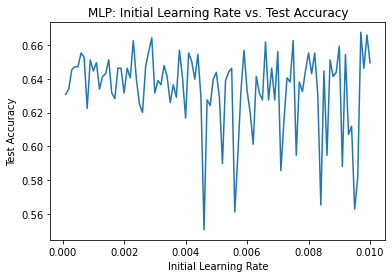

In [41]:
x_values = np.arange(0.0001, 0.01001, 0.0001)
y_values = []
for v in np.arange(100):
    y_values.append(max(test_accuracies[v*4:v*4+4]))
plt.plot(x_values, y_values)
plt.xlabel('Initial Learning Rate')
plt.ylabel('Test Accuracy')
plt.title('MLP: Initial Learning Rate vs. Test Accuracy')
plt.show()

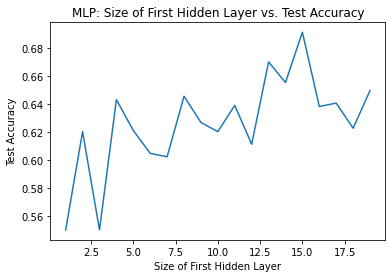

In [42]:
x_values = range(1, 20)
y_values = []
for v in range(19):
    y_values.append(max(h_lrs_test_accuracies[v*4:v*4+4]))
plt.plot(x_values, y_values)
plt.xlabel('Size of First Hidden Layer')
plt.ylabel('Test Accuracy')
plt.title('MLP: Size of First Hidden Layer vs. Test Accuracy')
plt.show()

# TFIDF PART

In [27]:
# fitting and defining tf-idf from our corpus
tfidfVec = TfidfVectorizer(preprocessor=preprocess_text, stop_words='english')
tfidfVec = tfidfVec.fit(merged_data)

## get tfidf feat rep
X_train = tfidfVec.transform(train_data)  
X_test = tfidfVec.transform(test_data)

## display
tf_idf_df=pd.DataFrame(X_train.toarray(),columns=tfidfVec.get_feature_names_out())
display(tf_idf_df.head(5).loc[:,tf_idf_df.head(5).any()])
print(tf_idf_df.head(5).loc[:,tf_idf_df.head(5).any()].iloc[:, : 10].to_markdown())

,annotation,answering,attention,base,based,bridge,cross,detection,effective,embedding,...,overlapping,projection,prototype,question,recognition,relation,representation,supervised,text,weakly
0,0.000000,0.00000,0.000000,0.000000,0.000000,0.467153,0.000000,0.000000,0.000000,0.299487,...,0.000000,0.000000,0.442089,0.00000,0.000000,0.000000,0.000000,0.000000,0.258115,0.00000
1,0.000000,0.00000,0.318779,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,0.330864,0.00000,0.000000,0.000000,0.000000,0.000000,0.286734,0.000000,0.330864,0.000000,...,0.000000,0.335106,0.000000,0.00000,0.227005,0.000000,0.252395,0.250016,0.000000,0.34673
3,0.000000,0.00000,0.000000,0.000000,0.215444,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.557273,0.000000,0.000000,0.00000,0.288827,0.000000,0.000000,0.000000,0.000000,0.00000
4,0.000000,0.36217,0.000000,0.429501,0.000000,0.000000,0.000000,0.306265,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.36217,0.000000,0.405613,0.000000,0.000000,0.000000,0.00000


|    |   annotation |   answering |   attention |     base |    based |   bridge |    cross |   detection |   effective |   embedding |
|---:|-------------:|------------:|------------:|---------:|---------:|---------:|---------:|------------:|------------:|------------:|
|  0 |     0        |     0       |    0        | 0        | 0        | 0.467153 | 0        |    0        |    0        |    0.299487 |
|  1 |     0        |     0       |    0.318779 | 0        | 0        | 0        | 0        |    0        |    0        |    0        |
|  2 |     0.330864 |     0       |    0        | 0        | 0        | 0        | 0.286734 |    0        |    0.330864 |    0        |
|  3 |     0        |     0       |    0        | 0        | 0.215444 | 0        | 0        |    0        |    0        |    0        |
|  4 |     0        |     0.36217 |    0        | 0.429501 | 0        | 0        | 0        |    0.306265 |    0        |    0        |


In [28]:
# Dimension reduction on TF-IDF using SVD
on_svd = False

'''
svd = TruncatedSVD(n_components=500, n_iter=10, random_state=42)
X_new = svd.fit_transform(X)
X_train_svd = X_new[0:len(train_data)]
X_test_svd = X_new[len(train_data):]
'''

'\nsvd = TruncatedSVD(n_components=500, n_iter=10, random_state=42)\nX_new = svd.fit_transform(X)\nX_train_svd = X_new[0:len(train_data)]\nX_test_svd = X_new[len(train_data):]\n'

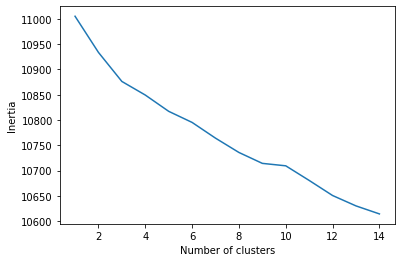

In [29]:
# cluster documents based on tf-idf scores
distortions = []
K = range(1,15)

for k in K:
    model = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10)
    if(on_svd):
        model.fit(X_train_svd)
    else:
        model.fit(X_train)
    distortions.append(model.inertia_)

plt.plot(K, distortions)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
# print(distortions)

# Choosing the best k from elbow method.
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=10)
if(on_svd):
    model.fit(X_train_svd)
else:
    model.fit(X_train)

Top terms per cluster:


/mnt/c/Users/Andre/miniconda3/envs/ml_proj/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


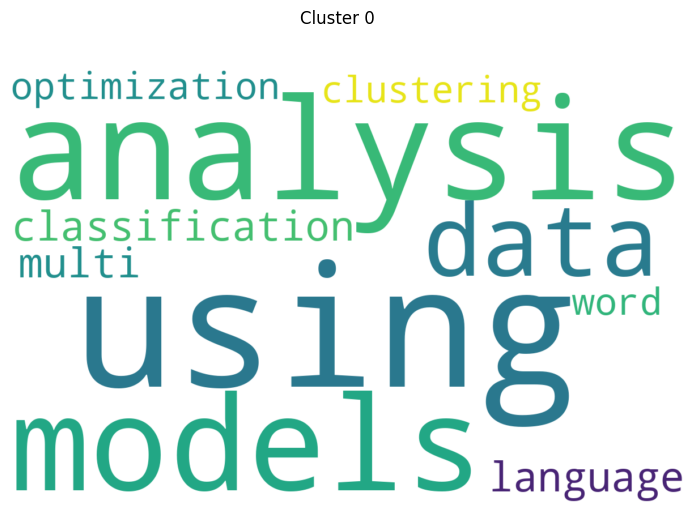

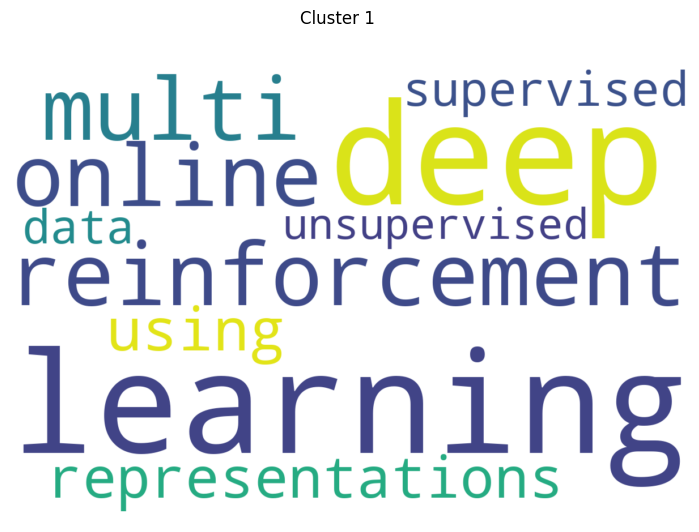

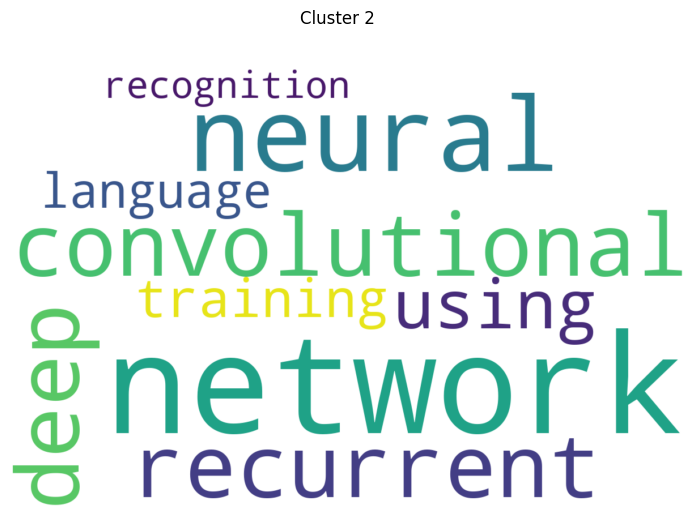

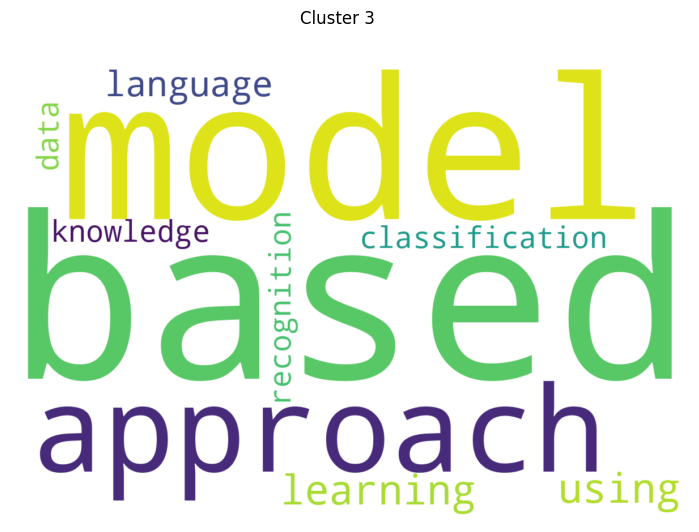

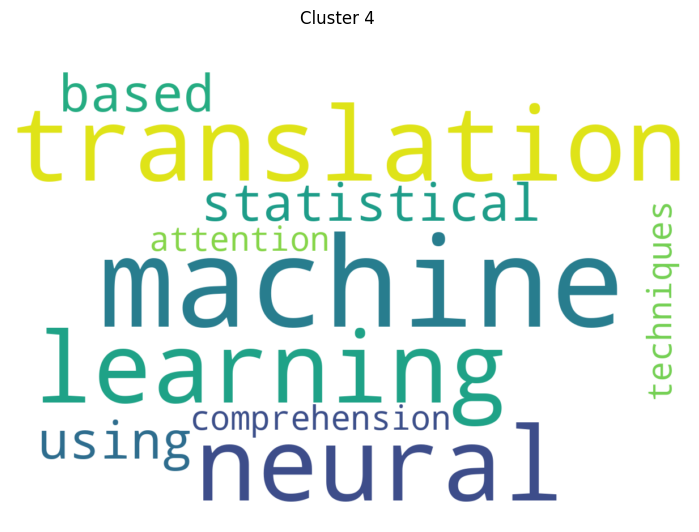

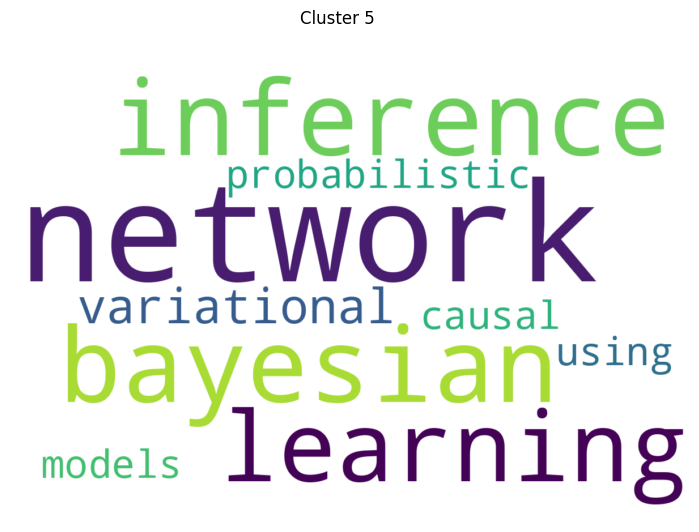

In [30]:
# Print top terms per cluster and generate word clouds
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidfVec.get_feature_names()
for i in range(true_k):
    # print("Cluster %d:" % i)
    words = ""
    for ind in order_centroids[i, :10]:
        words = words + terms[ind] + " "
        # print (' %s' % terms[ind])
    wordcloud = WordCloud(width=1200, height=800, background_color="white").generate(words)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    fig.suptitle(f"Cluster {i}")
    plt.show()

In [31]:
# Testing the Model
# Predict the cluster association of each paper
prediction = model.predict(X_test)
print(X_train.shape)
print(X_test.shape)
df = pd.DataFrame(list(zip(test_title, prediction)), columns =['Title', 'Cluster ID'])
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# display(df)
print(df.head(10).loc[:,df.head(10).any()].to_markdown())
# display(df.loc[df['Cluster ID'] == 1])

(11090, 9172)
(637, 9172)
|    | Title                                                                                              |   Cluster ID |
|---:|:---------------------------------------------------------------------------------------------------|-------------:|
|  0 | Evaluation Metrics for Machine Reading Comprehension: Prerequisite Skills and Readability          |            4 |
|  1 | A Neural Local Coherence Model                                                                     |            3 |
|  2 | Neural Modeling of Multi-Predicate Interactions for Japanese Predicate Argument Structure Analysis |            0 |
|  3 | Neural Disambiguation of Causal Lexical Markers based on Context                                   |            3 |
|  4 | Chunk-based Decoder for Neural Machine Translation                                                 |            4 |
|  5 | What do Neural Machine Translation Models Learn about Morphology?                                  |      

In [32]:
# BERT Encoding using SentenceTransformer and pre-trained distillbert model

embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
embeddings = embedder.encode(merged_data)

X_train = embeddings[0:len(train_data)]
X_test = embeddings[len(train_data):]

# K-means clustering on BERT encoding

bert_distortions = []
K = range(1,15)
for k in K:
    bert_model = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10)
    bert_model.fit(X_train)
    bert_distortions.append(bert_model.inertia_)

plt.plot(K, bert_distortions)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
# print(distortions)

# Choosing the best k from elbow method.
true_k = 6
bert_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=10)
bert_model.fit(X_train)

KeyboardInterrupt: 

In [ ]:
# Print top terms per cluster and generate word clouds for BERT model
print("Top terms per cluster:")
bert_order_centroids = bert_model.cluster_centers_.argsort()[:, ::-1]
terms = embeddings.get_feature_names()
for i in range(true_k):
    # print("Cluster %d:" % i)
    words = ""
    for ind in bert_order_centroids[i, :10]:
        words = words + terms[ind] + " "
        # print (' %s' % terms[ind])
    wordcloud = WordCloud(width=1200, height=800, background_color="white").generate(words)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    fig.suptitle(f"Cluster {i}")
    plt.show()

Top terms per cluster:


AttributeError: 'numpy.ndarray' object has no attribute 'get_feature_names'

In [ ]:
# Predict the clusters using BERT encoded model
bert_prediction = bert_model.predict(X_test)
print(X_train.shape)
print(X_test.shape)
bert_df = pd.DataFrame(list(zip(test_title, prediction)), columns =['Title', 'Cluster ID'])
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# display(df)
print(bert_df.head(10).loc[:,bert_df.head(10).any()].to_markdown())
# display(df.loc[df['Cluster ID'] == 1])